In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import geopandas as gpd
from mpl_toolkits.basemap import Basemap

In [2]:
awater = gpd.read_file("../../data/external_data/tl_2020_36_tract10/tl_2020_36_tract10.shp")

In [3]:
awater.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10',
       'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 'ALAND10', 'AWATER10',
       'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [4]:
awater.COUNTYFP10.value_counts()

047    761
081    669
005    339
103    323
061    288
      ... 
095      8
049      7
123      5
097      5
041      4
Name: COUNTYFP10, Length: 62, dtype: int64

In [5]:
counties = ['36005', '36047', '36061', '36081', '36085']
mask = awater.GEOID10.str[:5].isin(counties)
awater = awater[mask]

In [6]:
# take important columns
awater_df = awater[['GEOID10', 'ALAND10', 'AWATER10', 'geometry']]

In [7]:
# calculate percentage of water
awater_df['water_percentage'] = awater_df['AWATER10']/(awater_df['ALAND10'] + awater_df['AWATER10'])
awater_df['latitude'] = awater_df.apply(
    lambda row: row.geometry.centroid.x,
    axis=1
)
awater_df['longitude'] = awater_df.apply(
    lambda row: row.geometry.centroid.y,
    axis=1
)
C = 200
def app(row):
    lat_diff = awater_df['latitude'] - row.latitude
    long_diff = awater_df['longitude'] - row.longitude
    distance = lat_diff**2 + long_diff**2
    exp_dist = np.exp(-distance * C)
    weighted_exp_dist = exp_dist * awater_df['water_percentage']
    return weighted_exp_dist.sum() / exp_dist.sum()
awater_df['water_gaussian'] = awater_df.apply(
    lambda row: app(row),
    axis=1
)

/Users/yashgupta/opt/anaconda3/envs/py310/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/yashgupta/opt/anaconda3/envs/py310/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/yashgupta/opt/anaconda3/envs/py310/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to b

In [10]:
awater_df['longitude'].min(), awater_df['longitude'].max()

(40.499604888371444, 40.91404309278966)

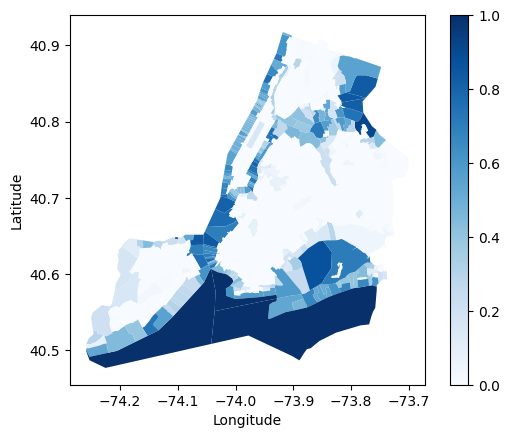

In [50]:
m = Basemap(llcrnrlon=-79, llcrnrlat=40.49, urcrnrlon=-71.96, urcrnrlat=45.01,
            resolution='i', projection='tmerc', lat_0=40.5, lon_0=-74.25)
awater_df.plot(ax=m.ax, column='water_percentage', cmap='Blues', legend=True)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [51]:
awater_df.to_csv('../../data/nyc_data/awater.csv', index=False)

In [52]:
awater_df.water_percentage.value_counts()

0.000000    1886
1.000000       4
0.255060       1
0.154677       1
0.263391       1
            ... 
0.573288       1
0.365105       1
0.390862       1
0.673214       1
0.708115       1
Name: water_percentage, Length: 280, dtype: int64

In [53]:
len(awater_df)

2168

greens

In [54]:
urban_tree_canopy = pd.read_csv('../../clean_data/greenspace_data/urban_tree_canopy.csv')

In [55]:
urban_tree_nyc = urban_tree_canopy[urban_tree_canopy.city_name == 'New York--Newark, NY--NJ--CT']

In [56]:
urban_tree_nyc['GEOID'] = urban_tree_nyc['census_block'].astype(str).str[:11]

/var/folders/5t/fxl9hmt15b9gy4kpwg48tz2w0000gn/T/ipykernel_89717/1484221862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urban_tree_nyc['GEOID'] = urban_tree_nyc['census_block'].astype(str).str[:11]


In [57]:
counties = ['36005', '36047', '36061', '36081', '36085']
mask = urban_tree_nyc.GEOID.str[:5].isin(counties)
urban_tree_nyc = urban_tree_nyc[mask]

In [58]:
cols1 = ['mean_percent_tree_cover', 'tree_gap', 'surface_temp', 'income_percent']
cols2 = ['income_group', 'pop_dens_group']

urban_tree_nyc = urban_tree_nyc[cols1 + cols2 + ['GEOID']]

In [59]:
dct = {}
for col in cols1:
    dct[col] = 'mean'
for col in cols2:
    dct[col] = 'mean'
urban_tree_nyc = urban_tree_nyc.groupby('GEOID').agg({**dct}).reset_index()

In [60]:
urban_tree_nyc

,GEOID,mean_percent_tree_cover,tree_gap,surface_temp,income_percent,income_group,pop_dens_group
0,36005000100,0.119340,0.085638,29.607333,2195.000000,1.000000,4.000000
1,36005000200,0.150475,0.161796,28.155665,24033.309524,1.619048,3.380952
2,36005000400,0.191821,0.197721,28.368855,33461.000000,3.000000,3.192308
3,36005001600,0.163306,0.159882,29.214966,15902.428571,1.071429,3.428571
4,36005001900,0.030956,0.177857,30.535067,19825.000000,1.000000,3.357143
...,...,...,...,...,...,...,...
2133,36085030301,0.051182,0.124848,30.450329,28667.931034,2.000000,3.689655
2134,36085030302,0.184980,0.159041,30.536584,25600.314286,2.000000,3.485714
2135,36085031901,0.318494,0.200355,29.174923,17132.000000,1.000000,3.133333
2136,36085031902,0.328307,0.146851,29.634628,22353.875000,1.291667,3.500000


In [61]:
urban_tree_nyc.to_csv('../../data/nyc_data/percent_tree_cover.csv', index=False)

In [62]:
merged = pd.merge(urban_tree_nyc, awater_df, left_on='GEOID', right_on='GEOID10', how='right')

In [63]:
merged

,GEOID,mean_percent_tree_cover,tree_gap,surface_temp,income_percent,income_group,pop_dens_group,GEOID10,ALAND10,AWATER10,geometry,water_percentage
0,36085024800,0.258494,0.255940,28.773062,34044.307692,2.403846,2.673077,36085024800,1649555,703149,"POLYGON ((-74.25817 40.50816, -74.25813 40.508...",0.298868
1,36085025100,0.157915,0.229124,29.317413,38426.911765,3.000000,2.750000,36085025100,1171699,0,"POLYGON ((-74.15356 40.61275, -74.15314 40.614...",0.000000
2,36085027301,0.173566,0.230324,28.408317,37002.142857,2.857143,2.928571,36085027301,3038370,1271,"POLYGON ((-74.16329 40.60168, -74.16248 40.604...",0.000418
3,36085027302,0.180818,0.169708,28.013129,31658.096774,2.387097,3.322581,36085027302,1021147,0,"POLYGON ((-74.14567 40.58997, -74.14563 40.590...",0.000000
4,36085030301,0.051182,0.124848,30.450329,28667.931034,2.000000,3.689655,36085030301,719319,0,"POLYGON ((-74.16848 40.62156, -74.16814 40.622...",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36081107202,7091507,17204004,"POLYGON ((-73.85352 40.58659, -73.84985 40.588...",0.708115
2164,36081012500,0.079528,0.111681,28.606574,35222.000000,3.000000,3.777778,36081012500,163049,0,"POLYGON ((-73.91988 40.77223, -73.91977 40.772...",0.000000
2165,36081029400,0.147562,0.154618,30.355713,28493.262295,2.000000,3.426230,36081029400,1064504,0,"POLYGON ((-73.78916 40.66834, -73.78883 40.669...",0.000000
2166,36081061301,0.091592,0.122183,29.283751,27688.631579,2.052632,3.736842,36081061301,712703,0,"POLYGON ((-73.90060 40.71270, -73.90018 40.712...",0.000000


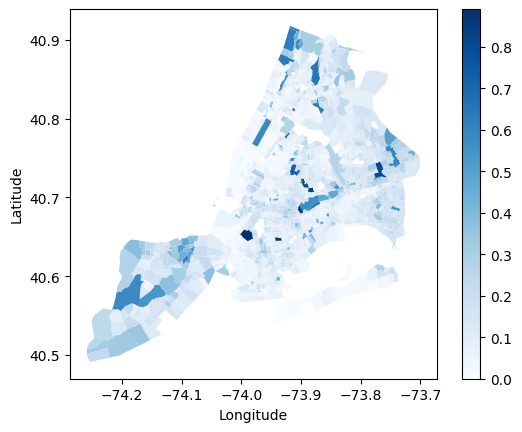

In [100]:
m = Basemap(llcrnrlon=-79, llcrnrlat=40.49, urcrnrlon=-71.96, urcrnrlat=45.01,
            resolution='i', projection='tmerc', lat_0=40.5, lon_0=-74.25)

gdf = gpd.GeoDataFrame(merged, geometry='geometry')
gdf.plot(ax=m.ax, column='mean_percent_tree_cover', cmap='Blues', legend=True)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [65]:
# get correlation as a heatmap
merged.corr().style.background_gradient(cmap='coolwarm')

/var/folders/5t/fxl9hmt15b9gy4kpwg48tz2w0000gn/T/ipykernel_89717/3100926814.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  merged.corr().style.background_gradient(cmap='coolwarm')


,mean_percent_tree_cover,tree_gap,surface_temp,income_percent,income_group,pop_dens_group,ALAND10,AWATER10,water_percentage
mean_percent_tree_cover,1.000000,0.426099,-0.291842,-0.180883,-0.032877,-0.428062,0.290722,0.039665,-0.019769
tree_gap,0.426099,1.000000,-0.125969,0.018350,0.092053,-0.991203,0.511942,0.246058,0.178859
surface_temp,-0.291842,-0.125969,1.000000,-0.346131,-0.337739,0.093901,-0.074986,-0.099874,-0.226313
income_percent,-0.180883,0.018350,-0.346131,1.000000,0.799802,-0.021842,-0.030790,0.033290,0.152358
income_group,-0.032877,0.092053,-0.337739,0.799802,1.000000,-0.114525,0.055054,0.088421,0.171628
pop_dens_group,-0.428062,-0.991203,0.093901,-0.021842,-0.114525,1.000000,-0.521152,-0.248767,-0.175610
ALAND10,0.290722,0.511942,-0.074986,-0.030790,0.055054,-0.521152,1.000000,0.073129,0.199412
AWATER10,0.039665,0.246058,-0.099874,0.033290,0.088421,-0.248767,0.073129,1.000000,0.293325
water_percentage,-0.019769,0.178859,-0.226313,0.152358,0.171628,-0.175610,0.199412,0.293325,1.000000


In [66]:
cehi = pd.read_csv('../../data/greenspace_data/cehi_merged.csv')

In [67]:
del cehi['city_state']

In [68]:
cehi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27776 entries, 0 to 27775
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   GEOID10                                 27776 non-null  int64  
 1   enviro_atlas_community_abbr             27776 non-null  object 
 2   avg_temp_reduction_tree_cover           27776 non-null  float64
 3   annual_percent_runoff_reduction         27776 non-null  float64
 4   high_speed_street_bordered_tree_buffer  27776 non-null  float64
 5   percent_residents_near_park             27776 non-null  float64
 6   percent_pm10_removed_trees              27776 non-null  float64
 7   percent_tree_view                       27776 non-null  float64
 8   percent_greenery_walkable_streets       27776 non-null  float64
 9   NID                                     27776 non-null  float64
 10  DwIndW                                  27776 non-null  fl

In [69]:
cehi.GEOID10 = cehi.GEOID10.astype(str).str[:11]

In [70]:
cehi = cehi.groupby('GEOID10').mean().reset_index()

/var/folders/5t/fxl9hmt15b9gy4kpwg48tz2w0000gn/T/ipykernel_89717/2767182474.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cehi = cehi.groupby('GEOID10').mean().reset_index()


In [71]:
merged = pd.merge(merged, cehi, left_on='GEOID', right_on='GEOID10', how='left')

In [72]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2167
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   GEOID                                   2138 non-null   object  
 1   mean_percent_tree_cover                 2138 non-null   float64 
 2   tree_gap                                2138 non-null   float64 
 3   surface_temp                            2138 non-null   float64 
 4   income_percent                          2138 non-null   float64 
 5   income_group                            2138 non-null   float64 
 6   pop_dens_group                          2138 non-null   float64 
 7   GEOID10_x                               2168 non-null   object  
 8   ALAND10                                 2168 non-null   int64   
 9   AWATER10                                2168 non-null   int64   
 10  geometry                                2168 non

In [73]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# df = merged
# fig, ax = plt.subplots(figsize=(20, 20))
# sns.heatmap(df.corr(), annot=True, fmt='.4f', 
#             cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
# ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
# plt.savefig('corr_nyc.png', bbox_inches='tight', pad_inches=0.0)

In [74]:
health = pd.read_csv('../../data/health_datasets/PLACES_2022_census_tract.csv')

In [75]:
health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2161543 entries, 0 to 2161542
Data columns (total 25 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Year                        int64  
 1   StateAbbr                   object 
 2   StateDesc                   object 
 3   CountyName                  object 
 4   CountyFIPS                  int64  
 5   LocationName                int64  
 6   DataSource                  object 
 7   Category                    object 
 8   Measure                     object 
 9   Data_Value_Unit             object 
 10  Data_Value_Type             object 
 11  Data_Value                  float64
 12  Data_Value_Footnote_Symbol  float64
 13  Data_Value_Footnote         float64
 14  Low_Confidence_Limit        float64
 15  High_Confidence_Limit       float64
 16  TotalPopulation             int64  
 17  Geolocation                 object 
 18  LocationID                  int64  
 19  CategoryID           

In [102]:
# health.Measure.value_counts()

In [76]:
mask = health.CountyFIPS.isin([int(x) for x in counties])
health = health[mask]

In [77]:
health = health.drop(columns=['States', 'Counties', 'LocationID', 'CategoryID', 'Geolocation', 'Data_Value_Footnote', 'Data_Value_Footnote_Symbol', 'Data_Value_Unit', 'DataSource', 'Data_Value_Type', 'DataValueTypeID', 'StateAbbr', 'StateDesc', 'CountyName', 'CountyFIPS'])

In [78]:
health.LocationName = health.LocationName.astype(str).str[:11]

In [79]:
vars = health.MeasureId.unique()

i = 0
mask = (health.MeasureId == vars[i])

print(vars[i])
merged_health = pd.merge(merged, health[mask], left_on='GEOID', right_on='LocationName', how='inner')

CSMOKING


In [103]:
# do regression using statsmodels
import statsmodels.regression.linear_model as sm

formula = 'surface_temp ~ mean_percent_tree_cover + water_percentage + mean_percent_tree_cover : water_percentage'
reg = sm.OLS.from_formula(formula, data=merged_health).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           surface_temp   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     88.81
Date:                Thu, 09 Feb 2023   Prob (F-statistic):           4.01e-54
Time:                        12:19:07   Log-Likelihood:                -2853.8
No. Observations:                2117   AIC:                             5716.
Df Residuals:                    2113   BIC:                             5738.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   29.1704      0.035    828.527      0.000      29.101      29.239
mean_percent_tree_cover                     -2.4606      0.236    -10.439      0.000      -2.923      -1.998
water_percentage                            -1.3379      0.197     -6.786      0.000      -1.725      -0.951
mean_percent_tree_cover:water_percentage    -2.0555      1.255     -1.637      0.102      -4.518       0.406
==============================================================================
Omnibus:                       63.481   Durbin-Watson:                   1.334
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.863
Skew:                          -0.408   Prob(JB):                     6.75e-16
Kurtosis:                       3.356   Cond. No.                         63.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
# add color
merged_health[['Data_Value', 'mean_percent_tree_cover', 'water_percentage']].corr().style.background_gradient(cmap='coolwarm')

,Data_Value,mean_percent_tree_cover,water_percentage
Data_Value,1.000000,0.039819,-0.086688
mean_percent_tree_cover,0.039819,1.000000,-0.019470
water_percentage,-0.086688,-0.019470,1.000000


In [82]:
#convert to list
# for i in range(len(vars)):
#     mask = (health.MeasureId == vars[i])
#     merged_health = pd.merge(merged, health[mask], left_on='GEOID', right_on='LocationName', how='inner')
#     formula = 'Data_Value ~ mean_percent_tree_cover + water_percentage + mean_percent_tree_cover : water_percentage'
#     reg = sm.OLS.from_formula(formula, data=merged_health).fit()
#     print(vars[i])
#     print(reg.summary())

In [ ]:
col1 = 'mean_percent_tree_cover'
col2 = 'water_percentage'

# do k means clustering
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=0).fit(merged_health[[col1, col2]])

# plot clusters
plt.scatter(merged_health[col1], merged_health[col2], c=km.labels_, cmap='rainbow')
plt.xlabel

In [84]:
merged_health['mean_percent_tree_cover'].value_counts()

0.000000    3
0.026238    1
0.063106    1
0.076079    1
0.173554    1
           ..
0.325183    1
0.085015    1
0.174479    1
0.114536    1
0.099487    1
Name: mean_percent_tree_cover, Length: 2115, dtype: int64

In [98]:
merged_health.geometry

0       POLYGON ((-74.25817 40.50816, -74.25813 40.508...
1       POLYGON ((-74.15356 40.61275, -74.15314 40.614...
2       POLYGON ((-74.16329 40.60168, -74.16248 40.604...
3       POLYGON ((-74.14567 40.58997, -74.14563 40.590...
4       POLYGON ((-74.16848 40.62156, -74.16814 40.622...
                              ...                        
2112    POLYGON ((-73.84102 40.71764, -73.84088 40.717...
2113    POLYGON ((-73.91988 40.77223, -73.91977 40.772...
2114    POLYGON ((-73.78916 40.66834, -73.78883 40.669...
2115    POLYGON ((-73.90060 40.71270, -73.90018 40.712...
2116    POLYGON ((-73.87930 40.71548, -73.87909 40.715...
Name: geometry, Length: 2117, dtype: geometry

In [107]:
health.to_csv('../../data/processed_data/health_nyc.csv', index=False)
merged.to_csv('../../data/processed_data/data_nyc.csv', index=False)